# K-means кластеризація для сегментації користувачів, заснованої на RFM змінних

У цьому ДЗ вирішуватимемо задачу сегментації користувачів, виходячи з їх нещодавності та частоти покупок, а також сум витрат на них.

Імпорти розташуйте під цією клітиною.

In [2]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import math
import seaborn as sns
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print(sns.__version__)

0.12.2


Будемо використовувати набір даних із наступного джерела: https://archive.ics.uci.edu/ml/datasets/online+retail

1.Завантажте набір даних із файлу. Виведіть перші 5 записів та розмір набору даних.

In [4]:
df = pd.read_excel('https://github.com/dmytrovelychko/rd_ds_python/raw/main/datasets/hw_6.xlsx')

In [ ]:
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Підготовка даних

2. Проведіть невеликий аналіз даних.
2.1.Виведіть результат методу describe() для числових колонок. Виведіть кількість унікальних значень у кожній категоріальній колонці.

In [ ]:
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


min і max дуже великий діапазон, особливо для quantity

In [ ]:
# Description = StockCode
df["StockCode"].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [ ]:
df["Country"].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

2.1.1.Як можна пояснити те, що у змінних Quantity і UnitPrice мінімальне значення негативне?

In [5]:
df_quantity_lt_0 = df[df["Quantity"] < 0]
df_quantity_lt_0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Quantity < 0, в інвойсах які описують відміну транзакції, згідно InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

Подивимось чи бувають інші випадки

In [24]:
df_quantity_lt_0_not_cancelled = df_quantity_lt_0[df["InvoiceNo"].apply(lambda x: str(x).lower().startswith("c")) == False]
df_quantity_lt_0_not_cancelled.head()

<ipython-input-24-41ea10e612eb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_quantity_lt_0_not_cancelled = df_quantity_lt_0[df["InvoiceNo"].apply(lambda x: str(x).lower().startswith("c")) == False]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom


як бачимо є інвойси не помічені як відміна але з відʼємною кількістю, перевіримо чи трапляются такі для конкретного користувача

In [27]:
df_quantity_lt_0_not_cancelled["CustomerID"].value_counts(dropna=False)

NaN    1336
Name: CustomerID, dtype: int64

Отже всі інвойси які НЕ позначені як відміна і мають відʼємне значення не привʼязані до користувача і будуть пізніше відсіяні із виборки, адже CustomerID з наявних даних не вийде запроксимувати (недостатньо додаткових даних, наприклад сесій користувачів і тд тп)

In [ ]:
df_unit_price_lt_0 = df[df["UnitPrice"] < 0]
print(df_unit_price_lt_0.shape)
df_unit_price_lt_0.head()

(2, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
df[df["StockCode"] == "B"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom



UnitPrice < 0, виглядає як перерахунок для зведення балансу, всі записи не мають CustomerID і будуть видалені пізніше

Заради цікавості оцінемо інвойси, коли UnitPrice == 0 або Quantity == 0.

In [30]:
df_with_cid = df[df["CustomerID"].notna()]
print(df_with_cid[df_with_cid["Quantity"] == 0].shape)
print(df_with_cid[df_with_cid["UnitPrice"] == 0].shape)

(0, 8)
(40, 8)


як бачимо є незначна кількість інвойсів користувачів з UnitPrice == 0, їх можна позбутись адже для RFM аналізу вони не несуть цінності

2.1.2. Як ви вважаєте, чи варто залишати ці дані (з негативними значеннями Quantity і UnitPrice) у наборі даних, виходячи з задачі, яку ми вирішуємо? Аргументуйте свою відповідь.
Якщо ви вважаєте, що ці рядки треба видалити, видаліть їх.

UnitPrice <= 0, записи або немають користувача або UnitPrice == 0, що в обох випадках не потібно для RFM аналізу

In [32]:
df = df[df["UnitPrice"] > 0]

Розглянемо що робити з Quantity <= 0

In [33]:
customers_cancelation_count = df_with_cid[df_with_cid["Quantity"] < 0].groupby("CustomerID")["CustomerID"].count()
customers_cancelation_count

CustomerID
12346.0     1
12352.0    10
12359.0     6
12362.0     8
12365.0     1
           ..
18272.0     4
18274.0    11
18276.0     2
18277.0     1
18282.0     1
Name: CustomerID, Length: 1589, dtype: int64

In [34]:
(customers_cancelation_count.shape[0]/df_with_cid.groupby("CustomerID").count().shape[0])*100

36.34492223238792

36.35% відсотків користувачів робили відміни (можливо це мається на увазі і повернення товару) з 01/12/2010 по 09/12/2011. Це значна кількість і може бути дослідженна як окрема катеогрія користувачів. У рамках RFM аналізу, їх видалення може дати біас по реальним витратам конкретного користувача. Подивимось як на конкретному прикладі

In [ ]:
customers_cancelation_count.sort_values(ascending=False)

CustomerID
14911.0    226
17841.0    136
17511.0    113
15311.0    112
12607.0    101
          ... 
15208.0      1
15213.0      1
15228.0      1
15241.0      1
18282.0      1
Name: CustomerID, Length: 1589, dtype: int64

In [ ]:
df[df["CustomerID"] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


Як бачимо якщо видалити запис відміни для користовуча 12346, ми отримаємо його витрати у вигляді Quantity*UnitPrice=77183,6 що в корні не вірно. Також можуть бути випадки:
- інвойси з частоковим поверненням
- в наш таймлайн датасету могли потрапити відміни товару, але не його покупка і навпаки

Проводити детальний мапінг даних, по кожному товару користувача і по кожному інвойсу видаливши всі інвойси які повністю були відмінені і тд, це доволі трудоємка задача. Пропоную такий trade-off:
- обраховуючи Recency, не враховуємо відміни, нас цікавить коли клієнт саме ініційовував покупку
- обраховуючи Frequency також враховуємо лише звичайні інвойси, важливо як часто була покупка а не поверення
- в Monetary врахуємо відміни, Monetary <=0 відкинемо, як користувачів з розірваним таймлайном інвойсів

Це не позбавить повністю від шуму, але до певної міри зкорегує Monetary для 36.35% користувачів


2.2.Виведіть відсоток відсутніх значень у кожній із колонок.

In [ ]:
(df.isna().sum() / df.shape[0]) * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.583791
Country         0.000000
dtype: float64

2.4. Видаліть рядки з відсутніми значеннями.

In [39]:
df = df[df["CustomerID"].notna()]

2.5. Виведіть значення змінної Country, відсортувавши їх за відсотком присутності в даних.
Тобто вгорі має бути значення, яке найчастіше є у даних.

In [ ]:
df["Country"].value_counts().sort_values(ascending=False)

United Kingdom          361854
Germany                   9493
France                    8490
EIRE                      7483
Spain                     2532
Netherlands               2367
Belgium                   2069
Switzerland               1876
Portugal                  1480
Australia                 1256
Norway                    1085
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         57
Lebanon                     45
Lithuani

2.6.У наборі даних є значення змінної Country, яке зустрічається найчастіше.
Відфільтруйте дані лише до тих записів, які мають значення змінної Country. Це спростить нам задачу, до того ж для інших значень Country обмаль даних.

In [36]:
df = df[df["Country"] == "United Kingdom"]
df.shape

(361854, 8)

2.7. Створіть стовпець Date із значень у стовпці InvoiceDate. Стовпець Date повинен містити дату у форматі рік-місяць-день, наприклад "2021-10-24".

In [37]:
df["Date"] = df["InvoiceDate"].apply(lambda x: x.date())

In [38]:
df["Date"].head()

0    2010-12-01
1    2010-12-01
2    2010-12-01
3    2010-12-01
4    2010-12-01
Name: Date, dtype: object

Отже, на даний момент у нас є всі необхідні дані для вирішення задачі:
- Customer ID
- Unit Price
- Quantity
- Invoice Date

## RFM

Давність-частота-грошовий вираз (Recency-Frequency-Monetary)
    
    
RFM-аналіз дозволяє сегментувати клієнтів за частотою та вартістю покупок та визначати тих клієнтів, які витрачають найбільше грошей.

* Давність - скільки часу пройшло з того часу, як клієнт щось купив у нас.
* Частота - як часто клієнт купує у нас.
* Грошовий вираз - загальна вартість покупок, здійснених покупцем.

Логічно припустити з опису вище, що **дані мають бути згруповані за клієнтами**. Інакше немає сенсу виводити Recency та Частоту.

3.1.Визначте останню дату транзакції у наборі даних. Ця дата нам необхідна, щоб визначати, як давно користувач робив покупку. Але дані історичні і якщо ми візьмемо для розрахунку recency фактичну сьогоднішню дату, розподіл recency буде зрушений у бік кількох сотень днів.
Щоб розподіл recency розпочинався з нуля, за дату "сьогодні" ми візьмемо дату останньої транзакції в наборі даних. Запишіть знайдену дату змінної NOW.

In [45]:
NOW = df["Date"].max()
NOW

datetime.date(2011, 12, 9)

### Recency

3.2.У змінну R_df запишіть recency dataframe, що складається з колонок CustomerID, Last_Purchase_Date та Recency,
де     
   - Last_Purchase_Date - це дата останньої покупки клієнта;
   - Recency - скільки днів минуло з дати останньої покупки клієнта до NOW.

In [48]:
# Recency рахуємо для інвойсів без врахування відмін
df_not_cancelled = df[df["InvoiceNo"].apply(lambda x: str(x).lower().startswith("c")) == False]
df_not_cancelled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [47]:
R_df = df_not_cancelled[df_not_cancelled["Quantity"] > 0].groupby("CustomerID")["Date"].max().to_frame("Last_Purchase_Date")
R_df["Recency"] = (NOW - R_df["Last_Purchase_Date"]).apply(lambda x: x.days)
R_df.head()

,Last_Purchase_Date,Recency
CustomerID,,
12346.0,2011-01-18,325
12747.0,2011-12-07,2
12748.0,2011-12-09,0
12749.0,2011-12-06,3
12820.0,2011-12-06,3


### Frequency - Monetary

3.3.Створіть Frequency - Monetary dataframe у змінній FM_df.  
Датафрейм повинен містити
- CustomerID - ідентифікатор клієнта
- Frequency - кількість покупок клієнта (кількість унікальних інвойсів)
- Monetary - скільки грошей у магазині витратив клієнт

In [49]:
FM_df = df_not_cancelled[df_not_cancelled["Quantity"] > 0].groupby("CustomerID")["InvoiceNo"].nunique().to_frame("Frequency")
FM_df.head()

,Frequency
CustomerID,
12346.0,1
12747.0,11
12748.0,209
12749.0,5
12820.0,4


In [50]:
# Monetary рахуємо з урахування відмін
df["Spending"] = df["Quantity"]*df["UnitPrice"]
FM_df["Monetary"] = df.groupby("CustomerID")["Spending"].sum().round(decimals=1)
FM_df.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,0.0
12747.0,11,4196.0
12748.0,209,29072.1
12749.0,5,3868.2
12820.0,4,942.3


Видалимо користувачів з Monetary <= 0, згідно прийнятому trade-off описаному вище

In [52]:
FM_df[FM_df["Monetary"] <= 0].shape

(18, 2)

In [53]:
FM_df = FM_df[FM_df["Monetary"] > 0]

### RFM
3.4.Створіть RFM_df, який є об'єднанням R_df та FM_df за ідентифікатором клієнта.

In [54]:
print(R_df.shape)
print(FM_df.shape)

(3920, 2)
(3902, 2)


треба звенрути увагу на різну розмірність

In [55]:
RFM_df = pd.concat([R_df, FM_df], axis=1, join="inner")
print(RFM_df.shape)
RFM_df.head()

(3902, 4)


,Last_Purchase_Date,Recency,Frequency,Monetary
CustomerID,,,,
12747.0,2011-12-07,2,11,4196.0
12748.0,2011-12-09,0,209,29072.1
12749.0,2011-12-06,3,5,3868.2
12820.0,2011-12-06,3,4,942.3
12821.0,2011-05-09,214,1,92.7


## K-means для RFM сегментації

K-means дає кращий результат за наступних умов:
- Розподіл даних не спотворений (тобто немає довгих хвостів)
- Дані стандартизовані (тобто середнє значення 0 та стандартне відхилення 1).

4.1.Побудуйте діаграми розподілу даних (наприклад, sns.distplot) для колонок Recency, Frequency і Monetary RFM_df.
Виведіть коефіцієнт асиметрії кожної з колонок.

In [56]:
def print_displot_asymmetry(series):
  sns.displot(series)
  print("skewneww:", series.skew())
  print("kurtosis:", series.kurt())

skewneww: 1.249796768263277
kurtosis: 0.45698821089181285


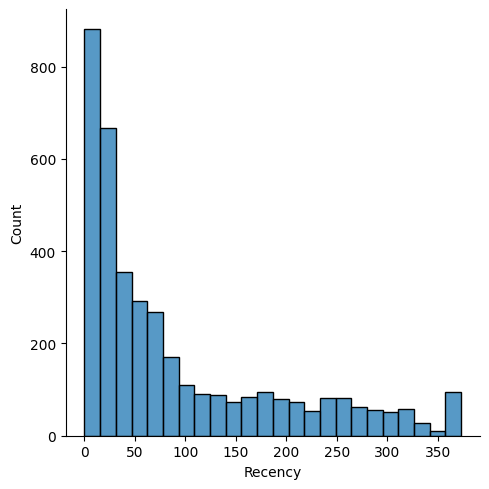

In [57]:
print_displot_asymmetry(RFM_df["Recency"])

skewneww: 10.73549929138971
kurtosis: 215.68934325860778


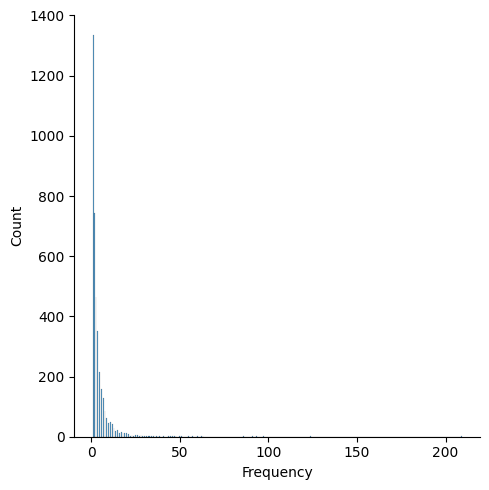

In [58]:
print_displot_asymmetry(RFM_df["Frequency"])

skewneww: 23.236604220849724
kurtosis: 757.2536673719961


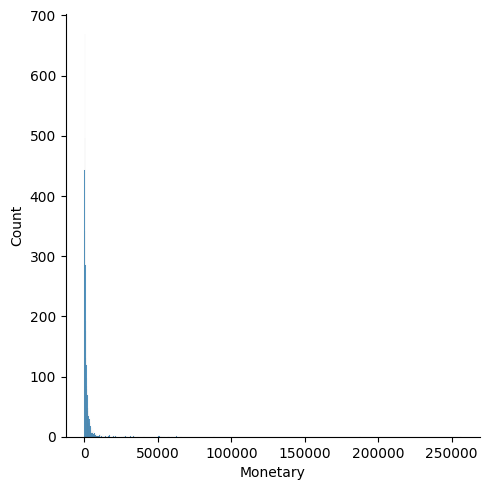

In [59]:
print_displot_asymmetry(RFM_df["Monetary"])

Дані сильно перекручені, тому ми виконаємо над ними log перетворення, щоб зменшити асиметрію кожної змінної.

4.2.Над кожною зі змінних 'Recency', 'Frequency', 'Monetary' виконайте перетворення log(x+1).   
Додаємо константу, оскільки log перетворення вимагає, щоб усі значення були позитивними.
Відобразіть розподіл змінних після перетворення.

In [60]:
RFM_df["RecencyLog"] = RFM_df["Recency"].apply(lambda x: math.log(x+1)) # log base = e
RFM_df["FrequencyLog"] = RFM_df["Frequency"].apply(lambda x: math.log(x+1))
RFM_df["MonetaryLog"] = RFM_df["Monetary"].apply(lambda x: math.log(x+1))

skewneww: -0.46025193316295
kurtosis: -0.4721376343791528


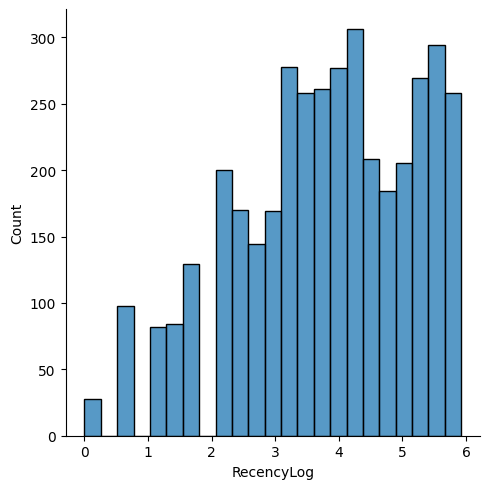

In [61]:
print_displot_asymmetry(RFM_df["RecencyLog"])

skewneww: 1.1775046436574939
kurtosis: 1.4957429096109687


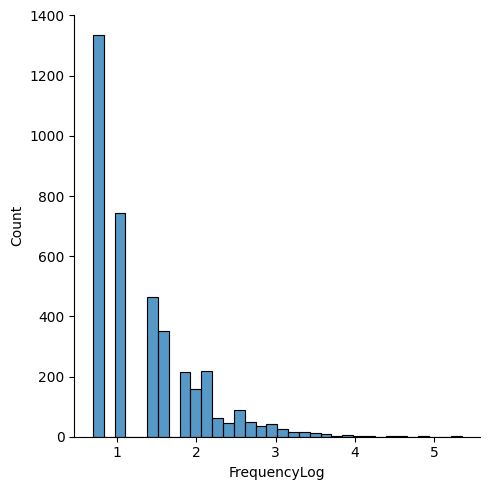

In [62]:
print_displot_asymmetry(RFM_df["FrequencyLog"])

skewneww: 0.34580790620034824
kurtosis: 0.5202459274383417


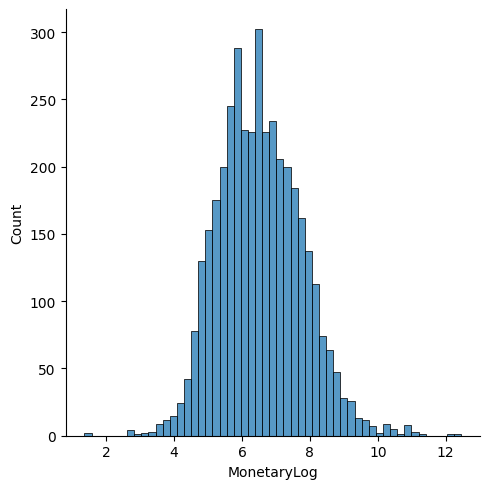

In [63]:
print_displot_asymmetry(RFM_df["MonetaryLog"])

4.3.Бачимо, що в нас все одно залишилися хвости. Приберемо їх з використанням техніки **Winsorizing**.    

Прочитайте про неї тут: https://en.wikipedia.org/wiki/Winsorizing.    

Для використання техніки будемо використовувати бібліотеку [feature_engine](https://feature-engine.readthedocs.io/en/1.1.x/).    
Встановіть її.


Нам потрібний об'єкт Winsorizer. Імпортуйте його за допомогою
`from feature_engine.outliers import Winsorizer`.

У змінній windsoriser створіть екземпляр класу Winsorizer зі значеннями змінних 'tail='both'', 'fold=2', а в 'variables' передайте назви змінних, які ми хочемо перетворити.
Викличте метод fit().

In [64]:
windsoriser = Winsorizer(tail='both', fold=2, variables=["RecencyLog", "FrequencyLog", "MonetaryLog"])
windsoriser.fit(RFM_df)

Winsorizer(fold=2, tail='both',
           variables=['RecencyLog', 'FrequencyLog', 'MonetaryLog'])

Викликаємо трансформацію:

In [65]:
RFM_winsorized_df = windsoriser.transform(RFM_df)

In [66]:
RFM_winsorized_df.head()

,Last_Purchase_Date,Recency,Frequency,Monetary,RecencyLog,FrequencyLog,MonetaryLog
CustomerID,,,,,,,
12747.0,2011-12-07,2,11,4196.0,1.098612,2.484907,8.342125
12748.0,2011-12-09,0,209,29072.1,1.028961,2.714106,8.986208
12749.0,2011-12-06,3,5,3868.2,1.386294,1.791759,8.260803
12820.0,2011-12-06,3,4,942.3,1.386294,1.609438,6.849384
12821.0,2011-05-09,214,1,92.7,5.370638,0.693147,4.540098


4.4. Стандартизуйте наші RFM змінні так, щоб середнє було 0, а стандартне відхилення дорівнювало 1. Тут не треба ділити на трейн і тест, можемо працювати разом з повним набором даних.

In [67]:
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM_winsorized_df[["RecencyLog", "FrequencyLog", "MonetaryLog"]])
RFM_scaled[:,0].std()

1.0

<Axes: ylabel='Density'>

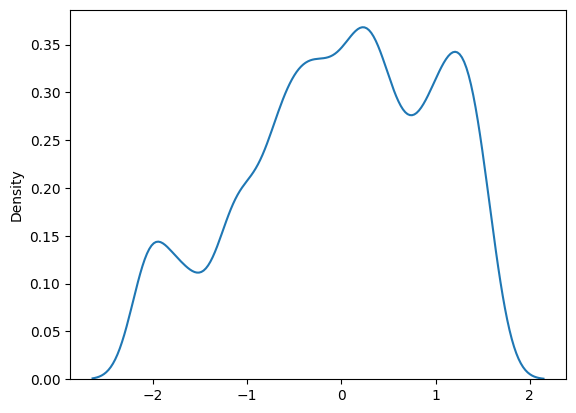

In [68]:
sns.kdeplot(RFM_scaled[:,0])

4.5. Знайдіть оптимальну кількість кластерів за допомогою Elbow Method.
Запустіть KMeans кластеризацію підготовлених стандартизованих RFM даних з параметром K від 1 до 10 включно.
Виконати це можна у циклі.
Відобразіть графічно отримані результати про значення сум внутрішньокластерних відстаней (у sklearn його називають inertia) для різних значень K.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

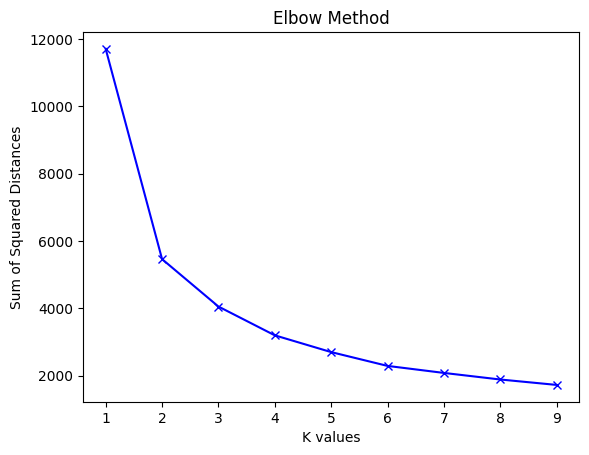

In [69]:
K = range(1,10)
sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters=k).fit(RFM_scaled)
    sum_of_squared_distances.append(model.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

Значення кластера, при якому зменшення значення inertia стає постійним, можна вибрати як правильне значення кластера для наших даних.
Спробуємо використовувати значення К від 3 до 5.

4.6.Створіть функцію, яка прийматиме набір даних для навчання (стандартизовані дані), значення К та набір даних з оригінальними (до стандартизації) значеннями (назвем його original_df_rfm).

Усередині функції необхідно
1. Навчити на стандартизованих даних Kmeans з кількістю кластерів К, що є аргументом функції.
2. Отримати ідентифікатори кластерів (лейбли).
3. Створити новий датафрейм як копію original_df_rfm.
4. До набору даних, отриманого в п.3, додайте колонку зі значенням кластера для даного рядка.
5. Виконайте зменшення розмірності за допомогою TSNE (можете спробувати замість TSNE використовувати PCA, і візуально порівняти результати).
6. Відобразити результати кластеризації.

Пункти 5 та 6 вже реалізовані за вас.
Запустіть функцію для значень K = {3,4,5}.
**Наша мета** - за допомогою візуалізацій зрозуміти, яка кількість кластерів оптимальна.

In [70]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def fit_visualize_kmeans(data_scaled, clusters_number, original_df_rfm):
    model = KMeans(n_clusters=clusters_number).fit(data_scaled)
    cluster_labels = model.predict(data_scaled)

    # Копия original_df_rfm с доп колонкой, содержащей лейблы кластеров

    df_new = original_df_rfm.copy()
    df_new["ClusterLabel"] = cluster_labels

    # Инициируем TSNE
    model = TSNE(random_state=1)
    # алгоритм кластеризації працював із стандартизованими підготовленими даними, для того
    # щоб візуально оцінити роботу алгоритму розмірність буду зменшувати на вхідних даних кластирезації
    transformed = model.fit_transform(data_scaled)

    # pca = PCA(random_state=1, n_components=2)
    # transformed = pca.fit_transform(data_scaled)
    # PCA виглядає охайніше але не допомогло мені краще обрати кількість кластерів

    # Визуализируем результаты TSNE трансформации
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    params = dict(
        x=transformed[:,0],
        y=transformed[:,1],
        hue=cluster_labels,
        style=cluster_labels,
        palette="Set1"
    )
    sns.scatterplot(**params)
    return df_new

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


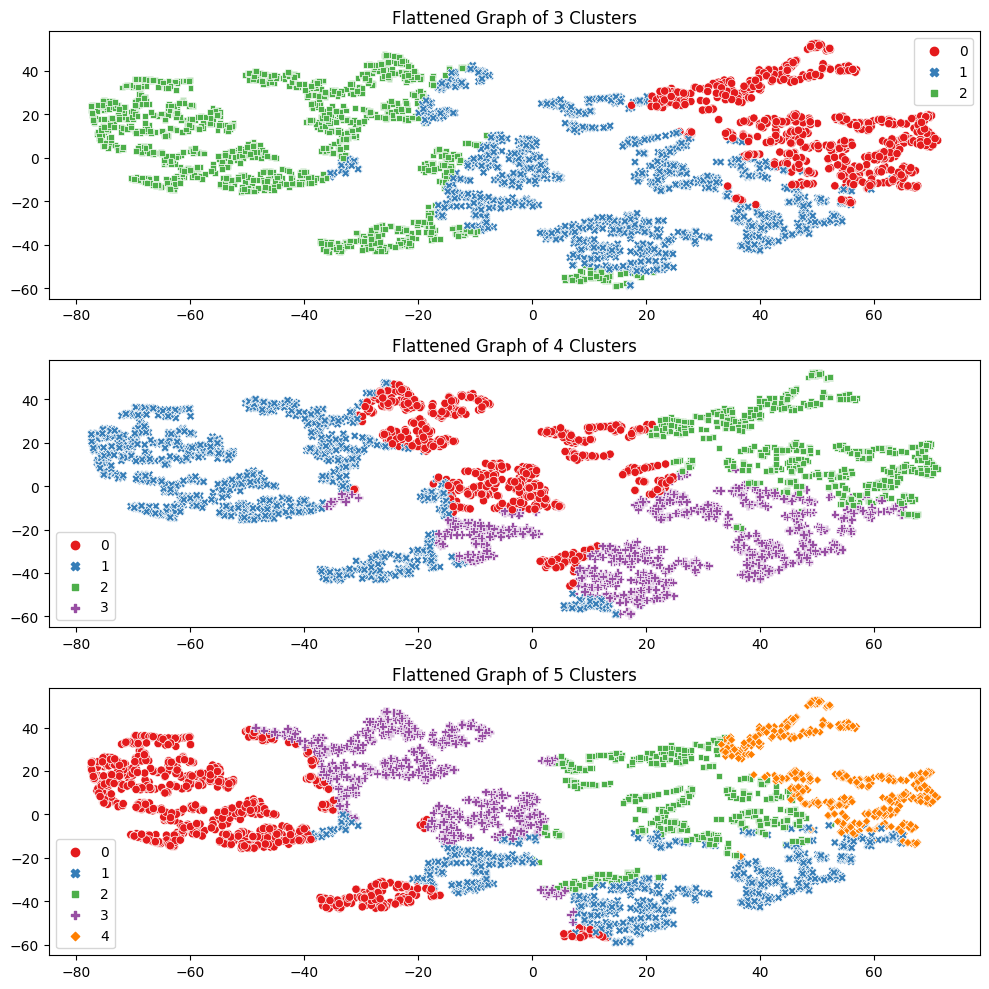

In [71]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = fit_visualize_kmeans(RFM_scaled, 3, RFM_df[["Recency", "Frequency", "Monetary"]])

plt.subplot(3, 1, 2)
df_rfm_k4 = fit_visualize_kmeans(RFM_scaled, 4, RFM_df[["Recency", "Frequency", "Monetary"]])

plt.subplot(3, 1, 3)
df_rfm_k5 = fit_visualize_kmeans(RFM_scaled, 5, RFM_df[["Recency", "Frequency", "Monetary"]])

plt.tight_layout()


Проаналізуйте отримані графіки. При якій кількості кластерів на вашій основі з візуалізацій найкраще поділяються дані на кластери?

На базі візуалізації 3,4 кластери краще розділені ніж 5, де багато точок на межі класів. Між 3 і 4 обрати візуально краще, бо багато межових точок що там що тамю

4.7.Збудуємо додатково [Snake plots](https://www.marketingprofs.com/tutorials/snakeplot.asp), які часто використовують у маркетингових аналізах.

Прочитайте про цей графік та давайте напишемо функцію для її реалізації.
У функції має відбуватися таке:
1. Створюємо датафрейм normalised_df_rfm, який містить оригінальні CustomerID, стандартизовані значення Recency, Frequency, Monetary та номер кластера.
2. Візуалізуємо датафрейм. Ця частина вже реалізована.  

Визначте відповідні аргументи функції самостійно. Вона має запускатися для різних результатів кластеризації.
Функція snake_plot може приймати декілька параметрів.

In [72]:
def snake_plot(data_scaled, df_rfm_labaled):
    normalised_df_rfm = df_rfm_labaled.copy()
    normalised_df_rfm["Recency"] = data_scaled[:,0]
    normalised_df_rfm["Frequency"] = data_scaled[:,1]
    normalised_df_rfm["Monetary"] = data_scaled[:,2]

    # "Розправляємо " дані в довгий формат
    df_melt = pd.melt(normalised_df_rfm.reset_index(),
                        id_vars=['CustomerID', 'ClusterLabel'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='ClusterLabel')

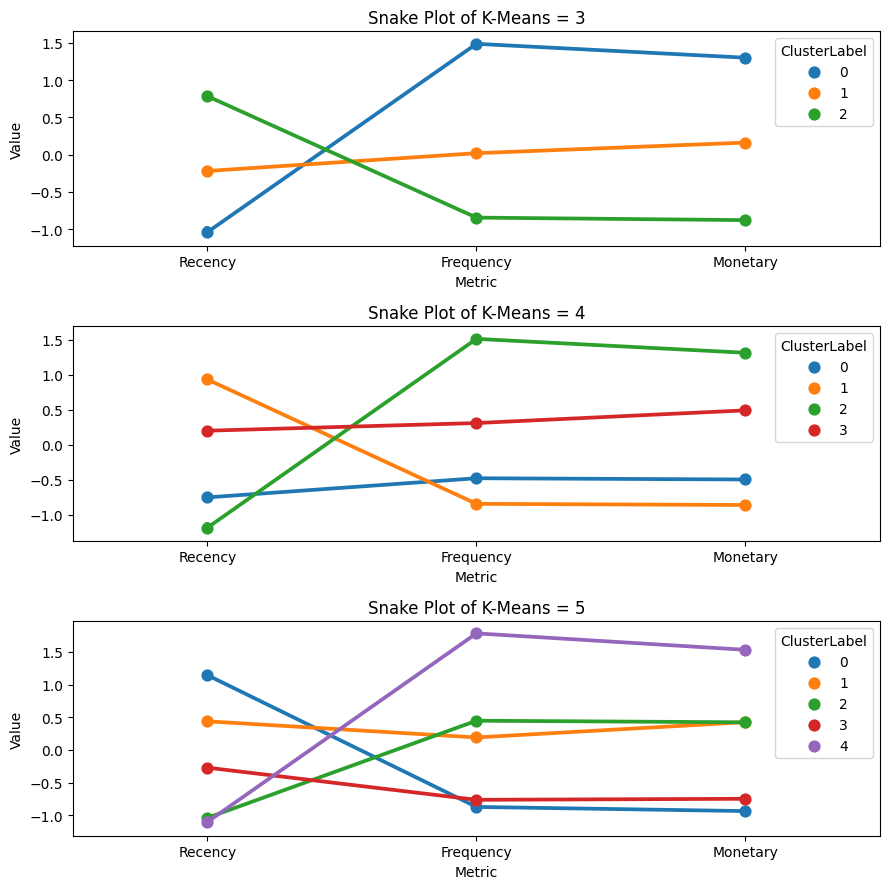

In [73]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_scaled, df_rfm_k3)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_scaled, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_scaled, df_rfm_k5)

plt.tight_layout()

Зі згладжених графіків і графіків-змій видно, що значення кластера, що дорівнює 4, добре сегментує наших клієнтів.
Ми також могли б піти на більшу кількість кластерів, що повністю залежить від того, як компанія хоче сегментувати своїх клієнтів. Але зазвичай 4 кластери – це зручно.

4.8.Інтерпретуємо результати кластеризації.
З результатів кластеризації з кількістю кластерів 4 (і оригінальними значеннями RFM змінних) сформуйте агрегат , який містить середнє значення по кожній із трьох колонок та кількість клієнтів у кластері.
Виведіть цей агрегат.

In [80]:
df_rfm_k4.groupby("ClusterLabel").agg({'Recency' : 'mean', 'Frequency' : 'mean', 'Monetary': ['mean', 'count']})

Recency  Frequency     Monetary      
                    mean       mean         mean count
ClusterLabel                                          
0              20.062246   1.933694   461.396617   739
1             187.767407   1.285926   303.850667  1350
2              12.680052  12.238342  5905.455570   772
3              75.371758   3.853987  1411.676081  1041

Зробіть висновки про отримані результати. Як би ви назвали кожний кластер? Які з них містять користувачів, що платять, а які - тих, хто потенційно піде у відтік?

- Cluster 0: купували нещодавно, але мало раз, швидше за все нові покупці
- Cluster 1: користувачі які втрачають активність, але робили покупки і мають відчутний вклад у прибутки
- Cluster 2: найактивніші користувачі, найбільш прибуткові
- Cluster 3: схоже на відтік, так як давно не мали активності, а коли мали то вона була незначна